In [ ]:
#| default_exp geometry


:::{.callout-tip}

This module can be imported using `from openhsi.geometry import *`

:::


:::{.callout-warning}

This is still under development. Stay tuned

:::



In [ ]:
#| hide

# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# bring forth **kwargs from an inherited class for documentation
from fastcore.meta import delegates

In [ ]:
#| export 

from fastcore.foundation import patch
from fastcore.meta import delegates
import numpy as np
import ctypes
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from numpy.linalg import norm
from functools import reduce
import psutil

In [ ]:
#| export
from openhsi.data import *
from openhsi.capture import ProcessDatacube

In [ ]:
#| export

class GeorectifyDatacube(ProcessDatacube):
    """Georectifify datacubes collected using the OpenHSI system."""
    def __init__(self, fname:str,   # path to a datacube
                 DEM_path:str=None, # path to DEM file
                 warn_mem_use:bool=True, # Give a warning if trying to allocate too much memory (> 80% of available RAM)
                ):
        """Load the elevation model at `DEM_path`. """
        self.fname = fname
        self.buff = DataCube()
        self.buff.load_nc(fname)
        if hasattr(self.buff,"ds_temperatures"):
            self.get_temp = lambda: -999 # this function needs to exist to create temperature buffer

        self.n_lines = self.buff.dc.data.shape[1]
        self.proc_lvl = -1
        self.timestamps = DateTimeBuffer(self.n_lines)
        
        if callable(getattr(self,"get_temp",None)):
            self.cam_temperatures = CircArrayBuffer(size=(self.n_lines,),dtype=np.float32)
        
        # calculate output datacube shape for preallocation!!!
        # must match cross-track, along-track, wavelength coordinates
        # will parse each along-track line and save the corresponding cross-track, wavelength 2D array
        self.dc_shape = (self.buff.dc.data.shape[0],self.n_lines,self.buff.dc.data.shape[2])
        mem_sz = 4*reduce(lambda x,y: x*y, self.dc_shape)/2**20 # MB
        mem_thresh = 0.8*psutil.virtual_memory().available/2**20 # 80% of available memory in MB
        if warn_mem_use and mem_sz > mem_thresh and input(f"{mem_sz:.02f} MB of RAM will be allocated. You have {mem_thresh/.8:.2f} MB available. Continue? [y/n]") != "y":
            raise RuntimeError(f"""Datacube memory allocation ({mem_sz:.02f} MB) exceeded >80% available RAM ({mem_thresh/.8:.2f} MB).
            Halted by user (did not receive `y` at prompt).
            To proceed, you can let `warn_mem_use=False`, decrease `n_lines`, use a `processing_lvl`>=2
            that includes binning, or continue anyway by entering `y` at the prompt.""")
        if self.dc_shape[0] > 1: print(f"Allocated {mem_sz:.02f} MB of RAM. There was {mem_thresh/.8:.2f} MB available.")
        self.dc = CircArrayBuffer(size=self.dc_shape, axis=1, dtype=np.float32)
        
        if DEM_path: self.DEM = 1
        

Allocated 572.06 MB of RAM for the load buffer. There was 5107.05 MB available.
Allocated 572.06 MB of RAM. There was 4560.30 MB available.
identity applied


<matplotlib.image.AxesImage>

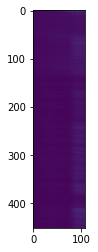

In [ ]:
#| external

proced_dc = GeorectifyDatacube(fname = "../may_trial_dataset_26th/2021_05_26-03_26_26_ELC.nc", 
                              DEM_path = None)

# add functions to a pipeline
identity = lambda x: x
proced_dc.load_next_tfms([identity])

# run the first line through the processing pipeline and put into output datacube buffer
proced_dc.put(proced_dc.get_img())
plt.imshow(proced_dc.dc.data[:,0,:])